# Lab 5: A Black-Box Adversarial Attack
In this lab, we'll carry out an adversarial attack in the **black box** case: we don't have the weights of the network we're trying to trick (the **target model**), and instead we can only give it inputs and see its outputs.

Black-box adversarial attacks are based on the fact that adversarial examples are _transferable_: if it tricks one network, it will likely trick another (but less well).
So, since we need network weights to make adversarial examples, we train a second model, the **surrogate model**, to act like the target model.
To do this, we'll use the target model as an "oracle" to make a dataset where the features are from real examples, and the labels are the outputs of the target model on those examples.
If the surrogate model learns to output the same probabilities as the target model on a given input, its internal representations are likely similar.
Then, when we make an adversarial example for the surrogate model, it should also trick the target model.

The end result of this lab should be an image which looks close to some image in the dataset, but tricks the target network into assigning high confidence to some other class. 

## Section 0: Load the data
This uses the same dataset as last time, so just copy the data over here in the same format.
The same data loading and preprocessing as before is in place.

In [1]:
%matplotlib inline
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os

In [2]:
# Seed numpy rng for reproducibility
np.random.seed(1337)

# Load data
x_all = np.load('data/X.npy')
y_all = np.load('data/Y.npy')

x_all = x_all.astype(np.float64)
y_all = y_all.astype(np.float64)

# Maps dataset-provided label to true label
label_map = {0:9, 1:0, 2:7, 3:6, 4:1, 5:8, 6:4, 7:3, 8:2, 9:5}

# Correct dataset labels
for row in range(y_all.shape[0]):
    dataset_label = np.where(y_all[row])[0][0]
    y_all[row, :] = np.zeros(10)
    y_all[row, label_map[dataset_label]] = 1
    
# Shuffle features and targets together
# Credit for this technique to:
# https://stackoverflow.com/questions/4601373/
# better-way-to-shuffle-two-numpy-arrays-in-unison
rng_state = np.random.get_state()
np.random.shuffle(x_all)
np.random.set_state(rng_state)
np.random.shuffle(y_all)

# Add a dummy channel axis to input images
x_all = np.expand_dims(x_all, axis=-1)

# Center and rescale data to the range [-1, 1]
x_all = x_all - 0.5
x_all = x_all * 2

# Create a validation set from 30% of the available data
n_points = x_all.shape[0]
n_test = int(n_points * 0.3)
n_train = n_points - n_test
x_train, x_test = np.split(x_all, [n_train], axis=0)
y_train, y_test = np.split(y_all, [n_train], axis=0)

## Section 1: Train the black-box model
Below, I've written a CNN in Keras to classify images from the dataset, and the code to train it.
This will act as the "black box model."

Train the model using the code below.
It should hit about 95-96% validation accuracy on the dataset.

In [3]:
from keras.models import Model
from keras.layers import Input, Conv2D, Dense, Flatten, MaxPool2D

inputs = Input(shape=(64, 64, 1))
layer = Conv2D(16, 5, strides=(2, 2), activation='relu')(inputs)
layer = Conv2D(16, 3, activation='relu')(layer)
layer = MaxPool2D()(layer)

layer = Conv2D(32, 3, activation='relu')(layer)
layer = Conv2D(32, 3, activation='relu')(layer)
layer = MaxPool2D()(layer)

layer = Conv2D(64, 3, padding='same', activation='relu')(layer)
layer = Conv2D(64, 3, padding='same', activation='relu')(layer)
layer = MaxPool2D()(layer)

layer = Flatten()(layer)
layer = Dense(128, activation='relu')(layer)
probs = Dense(10, activation='softmax')(layer)

target_model = Model(inputs, probs)
target_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 30, 30, 16)     │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 10, 10, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 5, 5, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 5, 5, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 106,234 (414.98 KB)

 Trainable params: 106,234 (414.98 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
from keras.optimizers import Adam

opt = Adam(1e-3)
target_model.compile(opt, loss='categorical_crossentropy',
              metrics=['accuracy'])

In [5]:
target_model.fit(x_train, y_train, 
                 validation_data=(x_test, y_test),
                 epochs=15)

Epoch 1/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.1130 - loss: 2.3020 - val_accuracy: 0.2104 - val_loss: 2.0976
Epoch 2/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3392 - loss: 1.7885 - val_accuracy: 0.6505 - val_loss: 0.9424
Epoch 3/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7004 - loss: 0.8578 - val_accuracy: 0.8414 - val_loss: 0.4605
Epoch 4/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8595 - loss: 0.4330 - val_accuracy: 0.8641 - val_loss: 0.4103
Epoch 5/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9050 - loss: 0.2796 - val_accuracy: 0.9126 - val_loss: 0.2860
Epoch 6/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9367 - loss: 0.1807 - val_accuracy: 0.9272 - val_loss: 0.2496
Epoch 7/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9626 - loss: 0.1086 - val_accuracy: 0.9466 - val_loss: 0.2053
Epoch 8/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9842 - loss: 0.0550 - val_accuracy: 0.8964 - v

## Section 2: Build an "oracle dataset" and data pipeline
Now, we'll treat the target model as a black box: pretend we don't have access to its weights or its original input data.
In the wild, all we can do is give it inputs and see its outputs.

We want to train a surrogate model to act similarly to the target model, so create a fake "oracle dataset" where the features are `x_all` and the outputs are the 10-vectors of probability the target model predicts for that input.

Then, set up any `tf.data.Dataset` objects you need.
In this case we don't have a test set, just a training set. Add `tf.summary.SummaryWriter`s to save logs to `./logs/surrogate` and `./logs/adversarial`.

In [6]:
oracle_outputs = target_model.predict(x_all, batch_size=128)

surrogate_dataset = tf.data.Dataset.from_tensor_slices((x_all, oracle_outputs))
surrogate_dataset = surrogate_dataset.shuffle(buffer_size=1024, reshuffle_each_iteration=True)
surrogate_dataset = surrogate_dataset.batch(64).prefetch(tf.data.AUTOTUNE)

# SummaryWriters
surrogate_log_dir = "./logs/surrogate"
adversarial_log_dir = "./logs/adversarial"

surrogate_writer = tf.summary.create_file_writer(surrogate_log_dir)
adversarial_writer = tf.summary.create_file_writer(adversarial_log_dir)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


## Section 3: Build a surrogate model
The surrogate model is designed to act similarly to the target model, so that adversarial examples we create for it will also work on the target model.
Feel free to use any architecture you want, but matching the target architecture closely (maybe with a bit more capacity) is a good bet.

Copy code from last week's assignment liberally.
Most likely, you won't have to write all that much new code in this section.

This should involve tensors that:
 - Act as hidden convolutional and dense layers
 - Compute the logits and probabilities for a batch of input images
 - Compute the predicted digit from the probabilities
 - Compute the mean cross-entropy loss over a batch

### 3.1 Dense and convolutional layers
Copy the `Dense` and `Conv` classes you wrote last week here.

In [7]:
class Dense(tf.Module):
    '''
    Creates a dense layer module.

    Parameters
    ----------
    dim_input: int
        Number of features in the input representation.
    dim_output: int
        Number of features in the output representation.
    do_activation: bool
        Whether or not to apply ReLU activation.
    postfix: string
        Postfix on name scopes in this layer.
    name: string
        Name of layer.
    '''
    def __init__(self, dim_input, dim_output, do_activation=True, postfix='', name=None):
        super().__init__(name=name)
        self.do_activation = do_activation
        self.dim_input = dim_input
        self.dim_output = dim_output

        with tf.name_scope('dense' + postfix):
            # Weight matrix shape: [input_dim, output_dim]
            self.w = tf.Variable(
                tf.initializers.he_uniform()(shape=(dim_input, dim_output), dtype=tf.float64),
                name='weights',
                dtype=tf.float64
            )
            # Bias vector shape: [output_dim]
            self.b = tf.Variable(
                tf.zeros_initializer()(shape=(dim_output,), dtype=tf.float64),
                name='bias',
                dtype = tf.float64
            )

    def __call__(self, x):
        z = tf.matmul(x, self.w) + self.b
        if self.do_activation:
            return tf.nn.relu(z)
        return z
    
class Conv(tf.Module):
    '''
    Creates a convolutional layer module.
    
    Parameters
    ----------
    input_channels: int
        Number of channels in the input representation.
    n_filters: int
        Number of channels in the output representation.
        Equivalently, number of filters in this layer.
    filter_size: int
        Width and height of each kernel in the layer's filters.
    stride: int
        Stride to use in the x and y directions for the
        convolution operation.
    do_activation: bool
        Whether or not to apply ReLU activation.
    pool_size: int
        If > 1, does max pooling of this size to the
        width and height axes of the activation.
    postfix: string
        Postfix on name and variable scopes in this layer.
        Used to simplify visualizations.
    name: string
        Name of layer
        
    Returns
    -------
    A tensor representing the activations of this layer.
    '''
    def __init__(self, input_channels, n_filters, 
                 filter_size=3, stride=1,
                 do_activation=True, pool_size=1,
                 postfix='', name=None):
        super().__init__(name=name)
        self.input_channels = input_channels
        self.n_filters = n_filters
        self.filter_size = filter_size
        self.stride = stride
        self.do_activation = do_activation
        self.pool_size = pool_size

        with tf.name_scope('conv' + postfix):
            # [filter_height, filter_width, in_channels, out_channels]
            self.filters = tf.Variable(
                tf.initializers.he_uniform()(shape=(filter_size, filter_size, input_channels, n_filters), dtype=tf.float64),
                name='filters',
                dtype=tf.float64
            )
            self.biases = tf.Variable(
                tf.zeros_initializer()(shape=(n_filters,), dtype=tf.float64),
                name='biases',
                dtype=tf.float64
)


    def image(self, x):
        '''
        Applies convolution and activation, but NOT pooling.
        Used for visualizing intermediate activations.
        '''
        conv_out = tf.nn.conv2d(
            x, self.filters, 
            strides=[1, self.stride, self.stride, 1], 
            padding='SAME')
        conv_out = tf.nn.bias_add(conv_out, self.biases)

        if self.do_activation:
            conv_out = tf.nn.relu(conv_out)

        return conv_out

    def __call__(self, x):
        '''
        Applies convolution, activation (if specified), and pooling (if pool_size > 1).
        '''
        x = self.image(x)

        if self.pool_size > 1:
            x = tf.nn.max_pool(
                x,
                ksize=[1, self.pool_size, self.pool_size, 1],
                strides=[1, self.pool_size, self.pool_size, 1],
                padding='VALID')

        return x

### 3.2: The rest of the model
Write a `tf.Module` class called `Surrogate` that uses your classes from last week to be your surrogate model.

In [8]:
class Surrogate(tf.Module):
    def __init__(self, name='surrogate'):
        super().__init__(name=name)

        self.conv1 = Conv(input_channels=1, n_filters=8, filter_size=3, stride=1, pool_size=2, postfix='1')
        self.conv2 = Conv(input_channels=8, n_filters=16, filter_size=3, stride=1, pool_size=2, postfix='2')
        self.conv3 = Conv(input_channels=16, n_filters=32, filter_size=3, stride=1, pool_size=2, postfix='3')
        self.dense1 = Dense(dim_input=2048, dim_output=128, do_activation=True, name='dense1')
        self.dense2 = Dense(dim_input=128, dim_output=10, do_activation=False, name='dense2')

        self.surrogate_optimizer = tf.optimizers.SGD(learning_rate=1e-3, momentum=0.9)
        self.adversarial_optimizer = tf.optimizers.Adam(learning_rate=1e-2)  # Higher LR often helps

        self.noise = tf.Variable(
            initial_value=tf.zeros([64, 64, 1], dtype=tf.float64),
            trainable=True,
            constraint=lambda x: tf.clip_by_value(x, -0.6, 0.6),
            name='adversarial_noise'
        )
        
        self.use_noise = tf.Variable(False, trainable=False, name='use_noise')

    def _noise_switch(self, x):
        def add_noise():
            x0_perturbed = x[0] + self.noise
            x_perturbed = tf.concat([tf.expand_dims(x0_perturbed, axis=0), x[1:]], axis=0)
            return x_perturbed

        return tf.cond(self.use_noise, true_fn=add_noise, false_fn=lambda: x)

    def logits(self, x):
        x = self._noise_switch(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = tf.reshape(x, [x.shape[0], -1]) 
        x = self.dense1(x)
        return self.dense2(x)

    def __call__(self, x):
        return tf.nn.softmax(self.logits(x))

    def _loss(self, x, y_true):
        logits = self.logits(x)
        per_example_loss = tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=logits)
        return tf.reduce_mean(per_example_loss)

    def _accuracy(self, x, y_true):
        logits = self.logits(x)
        preds = tf.argmax(logits, axis=1)
        labels = tf.argmax(y_true, axis=1)
        correct = tf.cast(tf.equal(preds, labels), tf.float64)
        return tf.reduce_mean(correct)
    
    def train(self, x, y, writer, step, adversarial=False):
        
        with tf.GradientTape() as tape:
            logits = self.logits(x)
            loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=logits))

            if not adversarial:
                gradients = tape.gradient(loss, self.trainable_variables)
                self.surrogate_optimizer.apply_gradients(
                    (grad, var) for grad, var in zip(gradients, self.trainable_variables) if grad is not None
                )

                acc = self._accuracy(x, y)
                with writer.as_default():
                    tf.summary.scalar('train/loss', loss, step=step)
                    tf.summary.scalar('train/accuracy', acc, step=step)

                return loss, acc

            else:
                adv_loss = -loss
                grads = tape.gradient(adv_loss, [self.noise])
                self.adversarial_optimizer.apply_gradients(zip(grads, [self.noise]))
                with writer.as_default():
                    tf.summary.scalar('adversarial/loss', adv_loss, step=step)
                    tf.summary.histogram('adversarial/noise_hist', self.noise, step=step)
                    tf.summary.image('adversarial/noise_image', tf.expand_dims(self.noise, axis=0), step=step)
                    tf.summary.image('adversarial/adversarial_example',
                                    tf.expand_dims(x[0] + self.noise, axis=0), step=step)

                return adv_loss, None

    def test(self, x, y, writer, step, image=False):
        if image:
            a1 = self.conv1.image(x)
            x1 = self.conv1(x)
            a2 = self.conv2.image(x1)
            x2 = self.conv2(x1)
            a3 = self.conv3.image(x2)

            with writer.as_default():
                for i in range(a1.shape[-1]):
                    tf.summary.image(f'activations/conv1/filter{i}', a1[..., i:i+1], step=step, max_outputs=1)
                for i in range(a2.shape[-1]):
                    tf.summary.image(f'activations/conv2/filter{i}', a2[..., i:i+1], step=step, max_outputs=1)
                for i in range(a3.shape[-1]):
                    tf.summary.image(f'activations/conv3/filter{i}', a3[..., i:i+1], step=step, max_outputs=1)

            return None, None

        loss = self._loss(x, y)
        acc = self._accuracy(x, y)

        with writer.as_default():
            tf.summary.scalar('test/loss', loss, step=step)
            tf.summary.scalar('test/accuracy', acc, step=step)

        return loss, acc

#### 3.2.1: Adversarial noise
This is the only part of the model that really differs from last week, and it's a bit tricky.

Add a variable that represents the adversarial noise we'll add to one example.
It should be the shape of a single input image and initialized to zeros.
In addition, pass (to the `Variable()` constructor) the keyword argument `constraint=lambda x: tf.clip_by_value(x, -0.3, 0.3)`.
Every time the variable is updated, it will become the result of the lambda function, which in this case constrains its pixel values to be in the range -0.3 to 0.3.
(Equivalently, at every step we re-project the adversarial noise back into a hypercube at the origin with side length 0.6).
I found that 0.3 works well, but feel free to change this value -- smaller values will produce less obvious noise, while larger values will produce more successful attacks. 

Add a boolean `tf.Variable` (default False) named "use_noise".
This will act as a "switch" controlling whether a given run uses adversarial noise. Additionally, add the argument `trainable=False` to the constructor, as it makes no sense to update this variable during training.

Add a `tf.cond()` operation that, depending on `use_noise`, switches between the input image and the image plus the adversarial noise.
This allows us to train the surrogate model without adversarial noise, then enable it when crafting the adversarial example.

### 3.3: Compute cross-entropy loss
Write a `_loss` function to compute the cross-entropy loss.

### 3.4: Surrogate and adversarial loss and gradients
Add an optimizer and train method we'll use to train the surrogate model to act like the target model.
It should just minimize the cross-entropy loss between the model's predictions and the targets. When `use_noise` is false, we will not have any gradients to update the adversarial noise tensor with because it will not be referenced in our computation. This will cause TensorFlow to throw (very annoying) warning messages about nonexistent gradients. To suppress this, we can use this neat trick (credit [here](https://stackoverflow.com/questions/60022462/how-to-suppress-specific-warning-in-tensorflow-python)) to preprocess our gradients,
```
gradients = g.gradient(loss, model.trainable_variables)
surrogate_optimizer.apply_gradients( 
                            (grad, var) for (grad, var) in zip(gradients, model.trainable_variables)
                             if grad is not None)
```

When training the surrogate model, we want to change the model parameters to minimize the loss.
When creating the adversarial example, we want to do something very different: _change the adversarial noise tensor alone to maximize the loss_.

So, add an `adversarial=False` argument to your train method so we can toggle whether or not to train the surrogate model, or the adversarial noise.

Define a new adversarial loss which is the negative of the original loss, and a new optimizer to minimize it.
When you call `minimize()`, pass in the keyword argument `var_list=[model.noise]`, where "noise" is the name of your adversarial noise tensor.
This will prevent the optimizer from changing the weights of the model when we optimize the adversarial noise.

Add a summary scalar to plot the adversarial loss decreasing. Then, add a summary histogram and a summary image for the adversarial noise tensor, so we can plot it as we're learning the adversarial example.
Finally, add a summary image for the output of `cond`, which will be our adversarial example later.

## Section 4: Train the surrogate model
Train your surrogate model until it hits high accuracy.
At the very least it should have 90% accuracy -- I hit 98-100% on the training set.
Overfitting isn't really a concern here since we are actually trying to memorize the target model.

When the training loop is done, save the model under `./checkpoints/model_surrogate`.
We won't be modifying this particular checkpoint any more, it'll contain the fully-trained surrogate model with zero adversarial noise.

In [9]:
# chkpt dir
checkpoint_dir = './checkpoints/model_surrogate'
os.makedirs(checkpoint_dir, exist_ok=True)

surrogate_model = Surrogate()
surrogate_model.use_noise.assign(False)

logdir = './logs/surrogate'
writer = tf.summary.create_file_writer(logdir)

max_epochs = 50
step = 0

for epoch in range(max_epochs):
    print(f"Epoch {epoch + 1}/{max_epochs}")
    
    for batch_x, batch_y in surrogate_dataset:
        loss, acc = surrogate_model.train(batch_x, batch_y, writer, step)
        step += 1

    # accuracy on training set
    full_accuracy = surrogate_model._accuracy(x_all, oracle_outputs).numpy()
    print(f"Training accuracy after epoch {epoch + 1}: {full_accuracy:.4f}")

# checkpoint
ckpt = tf.train.Checkpoint(model=surrogate_model)
ckpt.write(os.path.join(checkpoint_dir, 'ckpt'))
print(f"Model saved to {checkpoint_dir}/ckpt")


Epoch 1/50
Training accuracy after epoch 1: 0.3332
Epoch 2/50
Training accuracy after epoch 2: 0.5262
Epoch 3/50
Training accuracy after epoch 3: 0.6542
Epoch 4/50
Training accuracy after epoch 4: 0.7129
Epoch 5/50
Training accuracy after epoch 5: 0.7381
Epoch 6/50
Training accuracy after epoch 6: 0.7726
Epoch 7/50
Training accuracy after epoch 7: 0.7910
Epoch 8/50
Training accuracy after epoch 8: 0.8177
Epoch 9/50
Training accuracy after epoch 9: 0.8404
Epoch 10/50
Training accuracy after epoch 10: 0.8637
Epoch 11/50
Training accuracy after epoch 11: 0.8560
Epoch 12/50
Training accuracy after epoch 12: 0.8501
Epoch 13/50
Training accuracy after epoch 13: 0.8768
Epoch 14/50
Training accuracy after epoch 14: 0.8914
Epoch 15/50
Training accuracy after epoch 15: 0.8506
Epoch 16/50
Training accuracy after epoch 16: 0.8817
Epoch 17/50
Training accuracy after epoch 17: 0.9069
Epoch 18/50
Training accuracy after epoch 18: 0.9122
Epoch 19/50
Training accuracy after epoch 19: 0.9122
Epoch 20/50

## Section 5: Learn the adversarial example
Finally, it's time to create an adversarial example using our surrogate model.
Pick an image from the test set (or use the one I picked below), then run a training loop to minimize the adversarial loss (equivalently, maximize the model loss on that example).
To do this, use `surrogate_model.use_noise.assign(True)`.
This turns on the `use_noise` switch we set before, and overwrites the input image with the image we're going to turn into an adversarial example.

When it's done, save it to a new checkpoint, `./checkpoints/model_adversarial`.
This new checkpoint should have exactly the same model parameters as before (remember that we're only optimizing the noise), but a nonzero noise tensor.

At the end, also save the adversarial example (which will be contained in the result of your `cond`) and the noise tensor to a numpy array so we can use them later.

Periodically write the image and histogram summaries so you can look at them in TensorBoard later. 

You should be able to do this just by setting `adversarial=True` in your train method.

Text(0.5, 1.0, 'Label: 9')

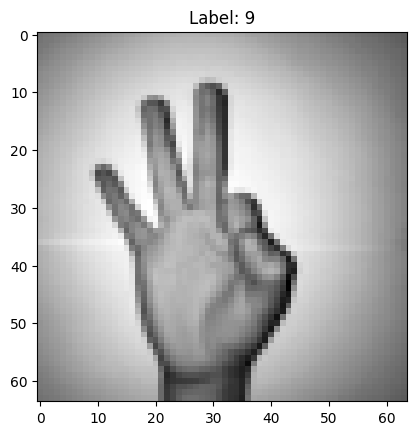

In [10]:
idx = 1
img = x_test[idx]
lbl = y_test[idx]

plt.imshow(img[:, :, 0], cmap='gray')
plt.title('Label: {}'.format(np.argmax(lbl)))

In [ ]:
adversarial_ckpt_dir = './checkpoints/model_adversarial'
os.makedirs(adversarial_ckpt_dir, exist_ok=True)

logdir_adv = './logs/adversarial'
adv_writer = tf.summary.create_file_writer(logdir_adv)

adversarial_model = Surrogate()
adversarial_model.use_noise.assign(True)

test_img = x_test[0:1]
true_label = y_test[0:1]

# train
num_steps = 1000  # or until loss converges
for step in range(num_steps):
    loss, _ = adversarial_model.train(test_img, true_label, adv_writer, step, adversarial=True)
    if step % 25 == 0:
        print(f"[Step {step}] Adversarial loss: {-loss.numpy():.4f}")

# save checkpoint
adv_ckpt = tf.train.Checkpoint(model=adversarial_model)
adv_ckpt.write(os.path.join(adversarial_ckpt_dir, 'ckpt'))
print(f"Adversarial model checkpoint saved to {adversarial_ckpt_dir}/ckpt")

# extract adversarial noise and example image
adv_example = test_img + adversarial_model.noise
adv_example = tf.clip_by_value(adv_example, -1.0, 1.0).numpy()
adv_noise = adversarial_model.noise.numpy()
np.save('adversarial_example.npy', adv_example)
np.save('adversarial_noise.npy', adv_noise)
print("Saved adversarial example and noise as .npy files.")


[Step 0] Adversarial loss: 2.6263
[Step 25] Adversarial loss: 12.0102
[Step 50] Adversarial loss: 23.2201
[Step 75] Adversarial loss: 33.5049
[Step 100] Adversarial loss: 38.7286
[Step 125] Adversarial loss: 41.9256
[Step 150] Adversarial loss: 44.0361
[Step 175] Adversarial loss: 45.4680
[Step 200] Adversarial loss: 46.4249
[Step 225] Adversarial loss: 47.0721
[Step 250] Adversarial loss: 47.7022
[Step 275] Adversarial loss: 48.1367
[Step 300] Adversarial loss: 48.5484
[Step 325] Adversarial loss: 48.8828
[Step 350] Adversarial loss: 49.2120
[Step 375] Adversarial loss: 49.5597
[Step 400] Adversarial loss: 49.8531
[Step 425] Adversarial loss: 50.0937
[Step 450] Adversarial loss: 50.3335
[Step 475] Adversarial loss: 50.5158
[Step 500] Adversarial loss: 50.6514
[Step 525] Adversarial loss: 50.7703
[Step 550] Adversarial loss: 50.8955
[Step 575] Adversarial loss: 51.0024
[Step 600] Adversarial loss: 51.1010
[Step 625] Adversarial loss: 51.2029
[Step 650] Adversarial loss: 51.2901
[Step 6

## Section 6: Visualize the adversarial example
Plot the original example, the adversarial example, and the adversarial noise below.

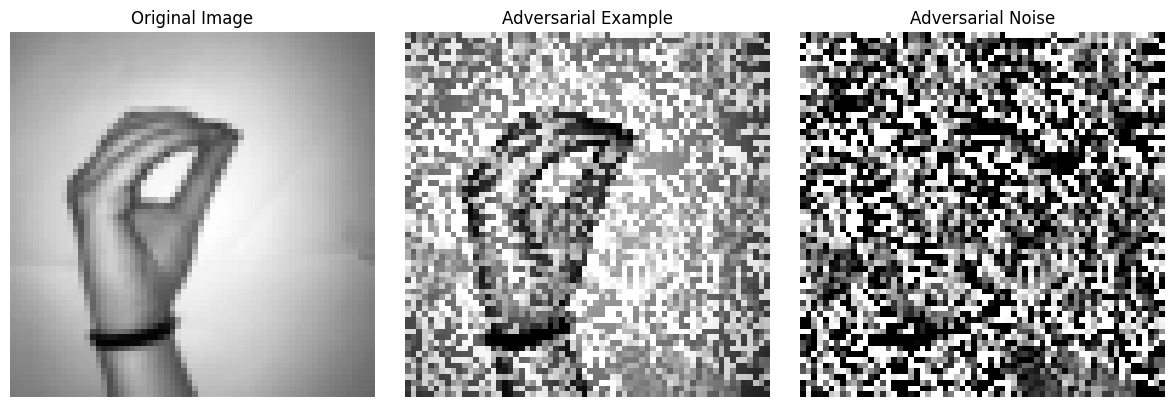

In [12]:
# remove batch dimension
original = test_img[0]
adversarial = adv_example[0]
noise = adv_noise 

# scale to range for visual
def to_display(img):
    return (img + 1.0) / 2.0

fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].imshow(to_display(original).squeeze(), cmap='gray')
axs[0].set_title("Original Image")
axs[0].axis('off')

axs[1].imshow(to_display(adversarial).squeeze(), cmap='gray')
axs[1].set_title("Adversarial Example")
axs[1].axis('off')

axs[2].imshow(to_display(noise.squeeze()), cmap='gray')
axs[2].set_title("Adversarial Noise")
axs[2].axis('off')

plt.tight_layout()
plt.show()

## Section 7: Demonstrate that the surrogate model fails on the adversarial example
Compute the surrogate model's prediction and probability for the original example and the adversarial example, and compare them. Remember to set the `use_noise` switch to false when computing predictions.

In [22]:
test_img = x_test[0:1]
true_label = y_test[0:1]

surrogate_model.use_noise.assign(False)

# original
logits_orig = surrogate_model.logits(test_img)
probs_orig = tf.nn.softmax(logits_orig)
pred_orig = tf.argmax(probs_orig, axis=1).numpy()[0]

# adversarial
adv_input = test_img + adversarial_model.noise 
logits_adv = surrogate_model.logits(adv_input)
probs_adv = tf.nn.softmax(logits_adv)
pred_adv = tf.argmax(probs_adv, axis=1).numpy()[0]

print("Original Image:")
print(f"  Predicted class: {pred_orig}")
print(f"  Probabilities: {probs_orig.numpy()[0]}")

print("\n Adversarial Example:")
print(f"  Predicted class: {pred_adv}")
print(f"  Probabilities: {probs_adv.numpy()[0]}")

Original Image:
  Predicted class: 0
  Probabilities: [9.99656167e-01 3.06066112e-04 2.14068511e-05 1.27269051e-05
 1.26979595e-07 6.99840305e-07 2.76454998e-06 2.60459074e-08
 3.40726038e-09 1.20816666e-08]

 Adversarial Example:
  Predicted class: 5
  Probabilities: [1.76693446e-06 4.22286914e-10 3.12828110e-14 6.16559382e-04
 8.67908309e-04 9.98416763e-01 9.70022603e-05 2.26947865e-12
 3.34945281e-15 1.54115041e-12]


## 8: Demonstrate that the target model fails on the adversarial example
This is the real test -- transferring the learned adversarial example from the surrogate model to the target model.
Compute the target model's prediction and probability for the original example and the adversarial example, and compare them.

In [20]:
preds_orig_target = target_model.predict(x_all, batch_size=128)
pred_labels_orig = np.argmax(preds_orig_target, axis=1)

# add noise to all images
adv_input = x_all + adversarial_model.noise

# predictions on noisy data
preds_adv_target = target_model.predict(adv_input, batch_size=128)
pred_labels_adv = np.argmax(preds_adv_target, axis=1)

# Ground truth labels
true_labels = np.argmax(y_all, axis=1)
accuracy_adv = np.mean(pred_labels_adv == true_labels)

print(f"Adversarial Accuracy of target model on x_all: {accuracy_adv * 100:.2f}%")

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Adversarial Accuracy of target model on x_all: 79.29%


In [19]:
x = 17
test_img = x_test[x:x+1]
true_label = y_test[x:x+1]

# original image prediction
preds_orig_target = target_model.predict(test_img)
pred_orig_target = np.argmax(preds_orig_target)

# adversarial example
adv_input = test_img + adversarial_model.noise
preds_adv_target = target_model.predict(adv_input)
pred_adv_target = np.argmax(preds_adv_target)

# Display results
print("Target Model on Original Image:")
print(f"  Predicted class: {pred_orig_target}")
print(f"  Probabilities: {preds_orig_target[0]}")

print("\nTarget Model on Adversarial Example:")
print(f"  Predicted class: {pred_adv_target}")
print(f"  Probabilities: {preds_adv_target[0]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Target Model on Original Image:
  Predicted class: 5
  Probabilities: [6.8839026e-13 1.0953194e-19 1.4110032e-17 2.6624124e-07 3.9220862e-07
 9.9998343e-01 1.4246546e-09 2.2276306e-11 8.4992777e-11 1.6002066e-05]

Target Model on Adversarial Example:
  Predicted class: 8
  Probabilities: [1.9457083e-09 4.9395004e-14 1.7755774e-11 1.0673761e-02 3.1381992e-03
 2.9151773e-01 6.4068467e-05 1.2634558e-04 6.7072588e-01 2.3753978e-02]


# Congratulations, you've carried out a black-box adversarial attack!
These kinds of adversarial attacks are a serious concern in the real world, since they can be [made to work when printed on paper](https://blog.openai.com/robust-adversarial-inputs/) and [we're still bad at defending against them](https://blog.openai.com/adversarial-example-research/).

Some interesting things to try:
 - Did the surrogate model and the target model misclassify the adversarial example in the same way? (Mine did)
 - How subtle can you make the noise while still tricking the target network?
 - Look at how the adversarial example evolves through training in TensorBoard